## Accessing Landsat data on Azure

This notebook demonstrates basic access to Landsat data on Azure, using the NASA CMR API to query for tiles, then accessing the tiles on Azure blob storage.  Because Landsat data are in preview, the user needs to provide storage credentials.

Landsat data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on Landsat data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop!  If you are using Landsat data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports

In [1]:
import re
import os
import datetime
import progressbar
import tempfile
import urllib
import shutil
import numpy as np
import matplotlib.pyplot as plt

import rasterio
import gdal

# From fiona
import rasterio.features

from azure.storage.blob import ContainerClient
from shapely.geometry import Point, Polygon
from cmr import GranuleQuery

### Constants

In [4]:
# Let's take a look at Seattle, which is at 47.6062° N, 122.3321° W
query_lon = -122.3321
query_lat = 47.6062

# Summer 2020... because cloudy images don't look good in demos, and
# it's cloudy in Seattle in the Winter
query_start_date = datetime.datetime(2020, 7, 1, 0, 0, 0)
query_end_date = datetime.datetime(2020, 9, 1, 0, 0, 0)

# This should be a text file with a SAS token for the Landsat container on the first line
sas_file = r'c:\git\ai4edev\datamanagement\test_data\landsat_ro_sas.txt' 

temp_dir = os.path.join(tempfile.gettempdir(),'landsat')
os.makedirs(temp_dir,exist_ok=True)

# Maps instrument names as they appear in CMR results to the short names used in filenames
instrument_mapping = {
    'Landsat 8 Operational Land Imager (OLI) and Thermal Infrared Sensor (TIRS) Collection 1 V1':
        'oli-tirs'}

# Normalization value for rendering
norm_value = 35000
        
# Select a thumbnail for thumbnail rendering (six are available for Landsat C2 files)
thumbnail_index = -3
        
# When rendering whole images, how much should we downscale?
dsfactor = 5

# Sensor to query the CMR for
# 
# Relevant values are: 
#
# Landsat1-5_MSS_C1
# Landsat4-5_TM_C1
# Landsat7_ETM_Plus_C1
# Landsat_8_OLI_TIRS_C1
#
query_short_name = 'Landsat_8_OLI_TIRS_C1'

### Azure storage constants

In [5]:
assert os.path.isfile(sas_file)
lines = []
with open(sas_file,'r') as f:
    lines = f.readlines()
assert len(lines) >= 1
sas_token = lines[0].strip()
        
storage_account_name = 'landsateuwest'
container_name = 'landsat-c2'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                                 container_name=container_name,
                                                 credential=sas_token)

### Search for granules

In [6]:
api = GranuleQuery()
granules = api.short_name(query_short_name).point(query_lon,query_lat).temporal(query_start_date, query_end_date).get()

print('Found {} granules:'.format(len(granules)))
for granule in granules:
    print(granule['title'])

Found 10 granules:
LC08_L1TP_046027_20200706_20200721_01_T1
LC08_L1TP_047027_20200729_20200807_01_T1
LC08_L1GT_139217_20200803_20200807_01_T2
LC08_L1TP_046027_20200807_20200821_01_T1
LC08_L1GT_138217_20200812_20200822_01_T2
LC08_L1TP_047027_20200814_20200822_01_T1
LC08_L1GT_139217_20200819_20200823_01_T2
LC08_L1TP_046027_20200823_20200905_01_T1
LC08_L1GT_138217_20200828_20200905_01_T2
LC08_L1TP_047027_20200830_20200906_01_T1


### Grab the first granule

In [7]:
granule = granules[0]

# E.g. 'LC08_L1TP_047027_20200103_20200113_01_T1'
granule_id = granule['title']
print('Accessing tile {}'.format(granule_id))

Accessing tile LC08_L1TP_046027_20200706_20200721_01_T1


### Map this to our Azure blob paths

In [8]:
level = 'level-2'
category = 'standard'
sensor = instrument_mapping[granule['dataset_id']]

# E.g., 2020-01-03T19:01:46.557Z
date = granule['time_start']
year = date[0:4]
month = date[5:7]
day = date[8:10]

path = granule_id[10:13]
row = granule_id[13:16]

row_folder = '/'.join([level,category,sensor,year,path,row])

# E.g. 01152004
granule_date_string = granule_id[11:19]

granule_month = granule_date_string[0:2]
granule_day = granule_date_string[2:4]
granule_year = granule_date_string[4:8]

# E.g. LC08_L1TP_047027_20200103
scene_prefix = granule_id[0:25]

# E.g. LC08_L2SP_047027_20200103
scene_prefix = scene_prefix[0:5] + 'L2SP' + scene_prefix[9:]

azure_scene_prefix = row_folder + '/' + scene_prefix

### Enumerate image files

In [9]:
generator = container_client.list_blobs(name_starts_with=azure_scene_prefix)
image_paths = [blob.name for blob in generator if blob.name.endswith('.TIF')]

print('Found {} images:'.format(len(image_paths)))
for fn in image_paths:
    print(fn.split('/')[-1])

Found 19 images:
LC08_L2SP_046027_20200706_20200913_02_T1_QA_PIXEL.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_QA_RADSAT.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_B1.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_B2.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_B3.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_B4.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_B5.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_B6.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_B7.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_SR_QA_AEROSOL.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_ATRAN.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_B10.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_CDIST.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_DRAD.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_EMIS.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_EMSD.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_QA.TIF
LC08_L2SP_046027_20200706_20200913_02_T1_ST_TRAD.TIF
LC08_L2SP_046027_20200706_20200913_

### Convert to Azure URLs

In [10]:
azure_urls = [storage_account_url + container_name + '/' + p + sas_token for p in image_paths]

### Make GDAL happy about SAS URLs

In [11]:
# GDAL gets a little unhappy with SSL access to Azure via SAS URLs in some situations;
# this fixues this issue.
#
# From:
# 
# http://gpsinfo.org/qgis-opening-remote-files-with-gdal-over-https-fails/
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.VSICurlClearCache()

### Extract geometry from COG without downloading, confirm the geometry contains our target point

In [13]:
query_point = Point(query_lon,query_lat)

url = [s for s in azure_urls if 'B1.TIF' in s][0]

# From:
#
# https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
with rasterio.open(url) as raster:
    
    mask = raster.dataset_mask()
    
    found_match = False
    
    # Extract feature shapes and values from the array
    #
    # Landsat COGs don't contain one simple polygon, they contain a
    # gazillion polygons.
    for geom, val in rasterio.features.shapes(
            mask, transform=raster.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            raster.crs, 'EPSG:4326', geom, precision=6)

        bbox = Polygon(geom['coordinates'][0])
    
        if query_point.within(bbox):
            found_match = True
            break

assert found_match

### Choose bands for an RGB composite

In [14]:
# From https://www.usgs.gov/media/images/common-landsat-band-rgb-composites
rgb_bands = ['B4','B3','B2']
rgb_urls = []
for band_name in rgb_bands:
    rgb_urls.append([s for s in azure_urls if band_name + '.TIF' in s][0])

### Render previews without reading the whole file

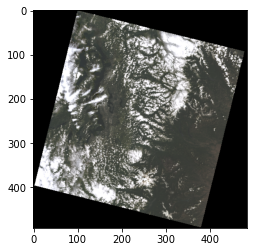

In [15]:
thumbnail_data = []

# url = rgb_urls[0]
for url in rgb_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve a small-ish thumbnail (six are available for Landsat files)
        decimation_level = oviews[thumbnail_index]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        thumbnail_channel = raster.read(1, out_shape=(1, h, w)) / norm_value
        thumbnail_data.append(thumbnail_channel)

rgb = np.dstack((thumbnail_data[0],thumbnail_data[1],thumbnail_data[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Download support functions

In [16]:
max_path_len = 255

class DownloadProgressBar():
    """
    https://stackoverflow.com/questions/37748105/how-to-use-progressbar-module-with-urlretrieve
    """
    
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(max_value=total_size)
            self.pbar.start()
            
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        # url_as_filename = url.replace('://', '_').replace('/', '_').replace('?','_').replace('&',
        url_without_sas = url.split('?', 1)[0]
        url_as_filename = re.sub(r'\W+', '', url_without_sas)
        n_folder_chars = len(temp_dir)
        if len(url_as_filename) + n_folder_chars > max_path_len:
            print('Warning: truncating filename target to {} characters'.format(max_path_len))
            url_as_filename = url_as_filename[-1*(max_path_len-n_folder_chars):]
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        url_no_sas = url.split('?')[0]
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url_no_sas)))
        return destination_filename
    print('Downloading file {} to {}'.format(os.path.basename(url),destination_filename),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename

### Download our three (R,G,B) tiles

In [17]:
filenames = []

for image_url in rgb_urls:
    fn = download_url(url=image_url,destination_filename=None,progress_updater=DownloadProgressBar())
    filenames.append(fn)

Bypassing download of already-downloaded file LC08_L2SP_046027_20200706_20200913_02_T1_SR_B4.TIF
Bypassing download of already-downloaded file LC08_L2SP_046027_20200706_20200913_02_T1_SR_B3.TIF
Bypassing download of already-downloaded file LC08_L2SP_046027_20200706_20200913_02_T1_SR_B2.TIF


### Render composite image

Resampling to 1578,1554
Resampling to 1578,1554
Resampling to 1578,1554


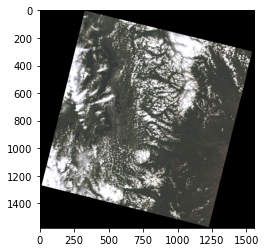

In [18]:
image_data = []

# fn = filenames[0]
for fn in filenames:
    with rasterio.open(fn,'r') as raster:
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        print('Resampling to {},{}'.format(h,w))
        band_array = raster.read(1, out_shape=(1, h, w))
        raster.close()
        band_array = band_array / norm_value
        image_data.append(band_array)

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Clean up temporary files

In [19]:
shutil.rmtree(temp_dir)